# Imports

In [1]:
!pip install simpletransformers -q

In [2]:
import pandas as pd
import numpy as np
import torch 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import wandb

# Load data

In [3]:
from google.colab import drive
import glob\

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
# CHANGE TO YOUR PATH
colab_resources_path = "/content/gdrive/MyDrive/projectml"

In [5]:
data_files = glob.glob(colab_resources_path + "/*.csv")
data_files += glob.glob(colab_resources_path + "/*.py")
for data_file in data_files:
  print('Copying file {} to colab root.'.format(data_file))
  !cp "$data_file" .

Copying file /content/gdrive/MyDrive/projectml/random.csv to colab root.
Copying file /content/gdrive/MyDrive/projectml/nam.csv to colab root.
Copying file /content/gdrive/MyDrive/projectml/am.csv to colab root.
Copying file /content/gdrive/MyDrive/projectml/am_additional.csv to colab root.
Copying file /content/gdrive/MyDrive/projectml/missclassified_roberta_mcc.csv to colab root.
Copying file /content/gdrive/MyDrive/projectml/miss_5models.csv to colab root.
Copying file /content/gdrive/MyDrive/projectml/missclassified_lr_robertas_ens_mcc.csv to colab root.
Copying file /content/gdrive/MyDrive/projectml/data_preprocess.py to colab root.


Get four different datasets from train data:


*   `train_data_title` - dataframe with article titles
*   `train_data_body` - dataframe will article bodies
*   `train_data_titleplus` - dataframe with article title + first sentence
*   `train_data_all` - dataframe with article title + body



In [6]:
from data_preprocess import getTrainData
train_data_title = getTrainData(include_random=True, random_as_2=False, shuffle=False, no_title=False, n_sentences=0) #for roberta on titles only
train_data_body = getTrainData(include_random=True, random_as_2=False, shuffle=False, no_title=True, n_sentences=-1) #for roberta on articles only
train_data_titleplus = getTrainData(include_random=True, random_as_2=False, shuffle=False, no_title=False, n_sentences=1) #for roberta on title+ 1 paraghaph only
train_data_all = getTrainData(include_random=True, random_as_2=False, shuffle=False, no_title=False, n_sentences=-1) #for roberta on all

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Split full train data on train and evalutaion dataframes for sweep.

In [15]:
train_df, eval_df = train_test_split(train_data_all, test_size=0.2, random_state=0)


# Sweep to tune hyperparameters

Choose hyperparameters to tune and their values

In [9]:
sweep_config = {
    "method": "bayes",  # grid, random
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"values": [2, 3, 4]},
        "learning_rate": {"min": 1e-6, "max": 4e-5},
        "max_grad_norm":{"min":0.1,"max":1.5}
    },
}

sweep_id = wandb.sweep(sweep_config, project="roberta")

Create sweep with ID: 04985qwv
Sweep URL: https://wandb.ai/frock/roberta/sweeps/04985qwv


Set other hyperparameters

In [10]:
model_args = ClassificationArgs(sliding_window=True)
model_args.tie_value = 1
model_args.batch_size = 16
model_args.eval_batch_size = 8
model_args.overwrite_output_dir = True
model_args.max_seq_length = 512
model_args.no_cache=True
model_args.use_multiprocessing = True
model_args.manual_seed = 4
model_args.reprocess_input_data = True
model_args.evaluate_during_training = True
model_args.labels_list = [0, 1]
model_args.wandb_project = "roberta"

Function for memory cleanup, useful if several models are trained in one notebook.

In [11]:
import gc
def memory_cleanup():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            del obj
    gc.collect()
    torch.cuda.empty_cache()
    !rm -r outputs

Define train function and start sweep

In [ ]:
def train():
    # Initialize a new wandb run
    wandb.init()

    # Create a TransformerModel
    model = ClassificationModel(
        "roberta",
        "roberta-base",
        use_cuda=True,
        args=model_args,
        sweep_config=wandb.config,
    )

    # Train the model
    model.train_model(train_df, eval_df=eval_df, acc=matthews_corrcoef)

    # Evaluate the model
    model.eval_model(eval_df)

    # Sync wandb
    wandb.join()


wandb.agent(sweep_id, train)

wandb: Agent Starting Run: zymjhdh7 with config:
wandb: 	learning_rate: 1.9836379778482304e-05
wandb: 	max_grad_norm: 1.176554135613485
wandb: 	num_train_epochs: 4
wandb: Currently logged in as: frock (use `wandb login --relogin` to force relogin)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:966: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Training loss,0.00013
lr,0.0
global_step,1880
_step,41
_runtime,953
_timestamp,1607745384
tp,152
tn,157
fp,5
fn,5
mcc,0.93729


Training loss,▅▁█▄█▁▇▁▅▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▄▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
tp,▁▂▅█
tn,▅██▁
fp,▅▁▁█
fn,█▇▄▁
mcc,▁▄██


wandb: Agent Starting Run: fihhqzi4 with config:
wandb: 	learning_rate: 3.475961154000497e-05
wandb: 	max_grad_norm: 1.4165015890823465
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:966: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Training loss,0.00021
lr,0.0
global_step,1880
_step,41
_runtime,959
_timestamp,1607746347
tp,151
tn,158
fp,4
fn,6
mcc,0.93735


Training loss,▃▁█▄▄▁▃▁▄▁▁▃▂▁▅▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▄▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
tp,▁█▇█
tn,█▁▃▃
fp,▁█▆▆
fn,█▁▂▁
mcc,▁█▇█


wandb: Agent Starting Run: zv0yhvo1 with config:
wandb: 	learning_rate: 2.3953522327690563e-06
wandb: 	max_grad_norm: 0.2849917114147417
wandb: 	num_train_epochs: 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Training loss,0.30053
lr,0.0
global_step,940
_step,20
_runtime,504
_timestamp,1607746857
tp,150
tn,154
fp,8
fn,7
mcc,0.90596


Training loss,▇▇▇▅▄▁█▅▄▁▁▃▆▁▇▁▄▄
lr,▄▇██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
global_step,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇██
tp,▁▁
tn,▁█
fp,█▁
fn,▁▁
mcc,▁█


wandb: Agent Starting Run: ce7zr7s4 with config:
wandb: 	learning_rate: 8.52979027088144e-06
wandb: 	max_grad_norm: 0.3238313520462864
wandb: 	num_train_epochs: 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Training loss,0.05678
lr,0.0
global_step,940
_step,20
_runtime,508
_timestamp,1607747369
tp,147
tn,160
fp,2
fn,10
mcc,0.92585


Training loss,▄▃▇▃▇▁█▁▄▁▃▃▃▁▄▁▄▁
lr,▄▇██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
global_step,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
tp,█▁
tn,▁█
fp,█▁
fn,▁█
mcc,█▁


wandb: Agent Starting Run: r37vr9j5 with config:
wandb: 	learning_rate: 1.3290029319195207e-05
wandb: 	max_grad_norm: 1.17298567299761
wandb: 	num_train_epochs: 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Training loss,0.01126
lr,0.0
global_step,940
_step,20
_runtime,499
_timestamp,1607747872
tp,146
tn,160
fp,2
fn,11
mcc,0.91987


Training loss,▅▂▆▄█▁█▁▄▁▁▄▆▁▄▁▄▁
lr,▄▇██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
global_step,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
tp,█▁
tn,▁█
fp,█▁
fn,▁█
mcc,█▁


wandb: Agent Starting Run: iqhgay4q with config:
wandb: 	learning_rate: 2.6728023256324858e-06
wandb: 	max_grad_norm: 0.13103724828354646
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Training loss,0.00154
lr,0.0
global_step,1880
_step,41
_runtime,948
_timestamp,1607748824
tp,150
tn,157
fp,5
fn,7
mcc,0.9248


Training loss,▆▆▆▅▄▁█▄▄▁▁▃▆▁█▁▇▄▁▆▅▁▁█▄▁▁▁▅▁▁▁▁▁▁▁▁
lr,▄▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
tp,▁█▅▅
tn,▁▅██
fp,█▅▁▁
fn,█▁▅▅
mcc,▁▇██


wandb: Agent Starting Run: o3ze9uol with config:
wandb: 	learning_rate: 3.9559220136957943e-05
wandb: 	max_grad_norm: 1.1990292322916343
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Training loss,0.00077
lr,0.0
global_step,1410
_step,31
_runtime,740
_timestamp,1607749568
tp,149
tn,156
fp,6
fn,8
mcc,0.91226


Training loss,▂▁█▂▃▂▃▂▃▁▁▁▁▁▃▁▁▁▁▁▄▁▁▁▁▁▁▁
lr,▄▇██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
global_step,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
tp,▁█▇
tn,█▁▃
fp,▁█▆
fn,█▁▂
mcc,▁██


wandb: Agent Starting Run: ycbmef3z with config:
wandb: 	learning_rate: 1.3075269467849782e-05
wandb: 	max_grad_norm: 0.29918451683574265
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run ycbmef3z errored: RuntimeError('CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run ycbmef3z errored: RuntimeError('CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: 6nmliwsd with config:
wandb: 	learning_rate: 3.5443032958621325e-05
wandb: 	max_grad_norm: 0.21739714809279892
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run 6nmliwsd errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run 6nmliwsd errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: 1qa6d6we with config:
wandb: 	learning_rate: 2.112054349843946e-05
wandb: 	max_grad_norm: 1.2261152243042241
wandb: 	num_train_epochs: 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run 1qa6d6we errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run 1qa6d6we errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: owf9wa7b with config:
wandb: 	learning_rate: 2.5500494127509292e-05
wandb: 	max_grad_norm: 0.18451193065593444
wandb: 	num_train_epochs: 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run owf9wa7b errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run owf9wa7b errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: 4xoossnk with config:
wandb: 	learning_rate: 3.925066600721088e-05
wandb: 	max_grad_norm: 1.1218027921486156
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run 4xoossnk errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run 4xoossnk errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: 2blmnpzu with config:
wandb: 	learning_rate: 3.4306004828351206e-05
wandb: 	max_grad_norm: 0.6205878586567474
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run 2blmnpzu errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run 2blmnpzu errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: eqohfp3w with config:
wandb: 	learning_rate: 3.729071752690183e-05
wandb: 	max_grad_norm: 0.27981061466711665
wandb: 	num_train_epochs: 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run eqohfp3w errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run eqohfp3w errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: q4jvpg65 with config:
wandb: 	learning_rate: 3.870362596119579e-05
wandb: 	max_grad_norm: 0.5834188000127539
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run q4jvpg65 errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run q4jvpg65 errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: 9o9izfvp with config:
wandb: 	learning_rate: 1.455569106529204e-05
wandb: 	max_grad_norm: 1.3427626859019297
wandb: 	num_train_epochs: 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run 9o9izfvp errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run 9o9izfvp errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: kql63dj8 with config:
wandb: 	learning_rate: 1.4339026359011602e-05
wandb: 	max_grad_norm: 0.19643283674928103
wandb: 	num_train_epochs: 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run kql63dj8 errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run kql63dj8 errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: q7ikxcj2 with config:
wandb: 	learning_rate: 3.958657374736565e-05
wandb: 	max_grad_norm: 0.7029177302014677
wandb: 	num_train_epochs: 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Run q7ikxcj2 errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: ERROR Run q7ikxcj2 errored: RuntimeError('CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 14.73 GiB total capacity; 13.56 GiB already allocated; 11.88 MiB free; 13.67 GiB reserved in total by PyTorch)',)
wandb: Agent Starting Run: dp0qaman with config:
wandb: 	learning_rate: 3.193759921144488e-05
wandb: 	max_grad_norm: 0.9710794514382454
wandb: 	num_train_epochs: 4


Sweep results

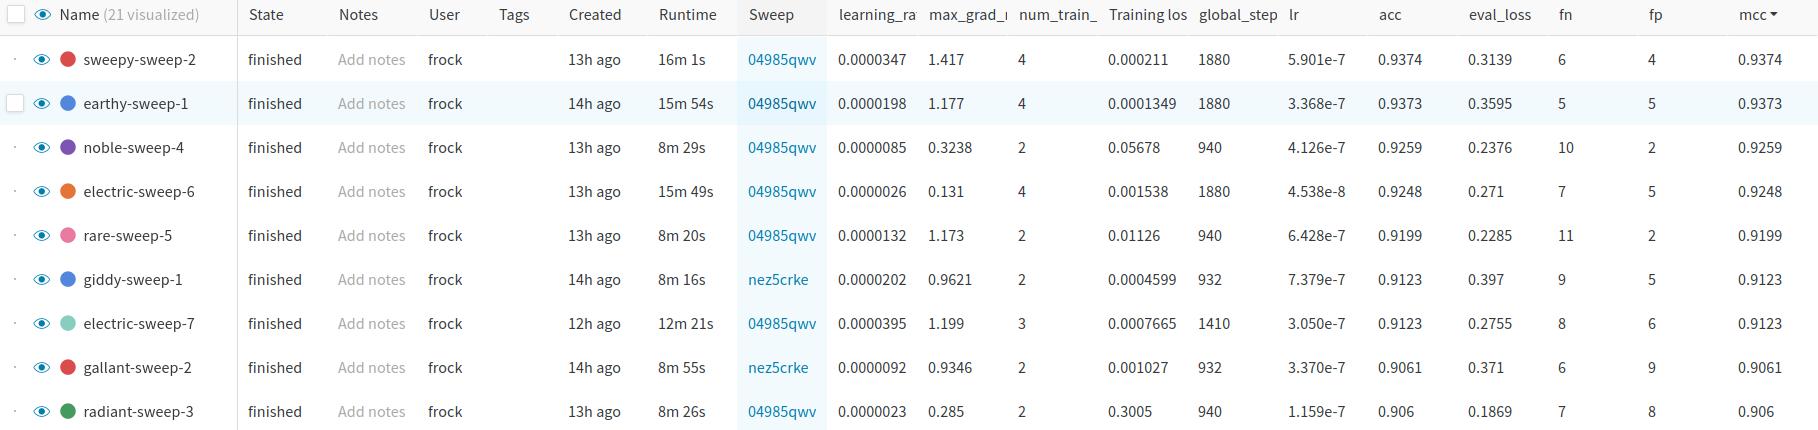

*earthy-sweep-1* model has `learning_rate` = 1.98e-5, `max_grad_clipping` = 1.177 and `num_train_epochs` = 4

Our RoBERTa models in other notebooks has `learning_rate` = 2e-5, `max_grad_clipping` = 1.0 and `num_train_epochs` = 4

Model in *earthy-sweep-1* has the second highest MCC and equal amounts of false negatives and false positives, therefore we assume that these parameters are close to optimal. As our standard hyperparameters for RoBERTa are very close to hyperparameters in *earthy-sweep-1*, we decided not to change them.